Training without weight minimization...
Training with eigenvector-based weight minimization...


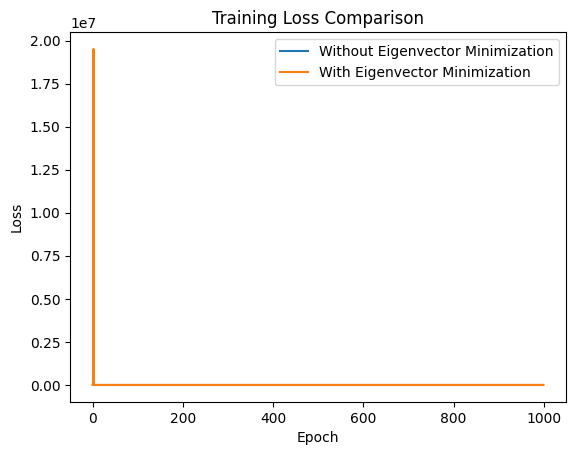

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the neural network with 4 fully connected layers
class FourLayerNet(nn.Module):
    def __init__(self):
        super(FourLayerNet, self).__init__()
        # 4 fully connected layers, each with 4 neurons
        self.fc1 = nn.Linear(4, 4)
        self.fc2 = nn.Linear(4, 4)
        self.fc3 = nn.Linear(4, 4)
        self.fc4 = nn.Linear(4, 4)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)  # No activation in the last layer for simplicity
        return x

# Function to transform weights into eigenvector basis and minimize eigenvalues exponentially
def eigen_basis_exponential_minimization(layer, alpha=0.01):
    alpha = torch.tensor(alpha)
    # Extract the weight matrix (ignoring bias for simplicity)
    W = layer.weight.data

    # Check for NaNs or Infs in the weight matrix
    if torch.isnan(W).any() or torch.isinf(W).any():
        print("Warning: Weight matrix contains NaN or Inf values. Skipping this layer.")
        return

    # Clamp the weight matrix to avoid large values
    W = torch.clamp(W, min=-1e5, max=1e5)
    
    # Ensure the weight matrix is square
    if W.size(0) != W.size(1):
        print("Skipping non-square weight matrix.")
        return
    
    # Compute the eigenvalues and eigenvectors of W
    eigenvalues, eigenvectors = torch.linalg.eig(W)
    
    # Take the real part of the eigenvalues and eigenvectors (assume real-valued matrix)
    real_eigenvalues = eigenvalues.real
    real_eigenvectors = eigenvectors.real

    # Print eigenvalues for debugging
    # print("Real Eigenvalues:", real_eigenvalues)
    
    # Apply exponential minimization on the eigenvalues
    minimized_eigenvalues = real_eigenvalues * torch.exp(-alpha)
    
    # Reconstruct the diagonal matrix with minimized eigenvalues
    diagonal_matrix = torch.diag(minimized_eigenvalues)
    
    # Transform the weight matrix back using eigenvectors
    new_W = torch.mm(real_eigenvectors, torch.mm(diagonal_matrix, torch.inverse(real_eigenvectors)))
    
    # Update the weights of the layer
    layer.weight.data = new_W.float()  # Ensure that weights are in the correct float type


# Create synthetic training data
def generate_synthetic_data(num_samples=1000):
    # Generate random input of shape (num_samples, 4)
    X = torch.randn(num_samples, 4)
    # Define a target as a linear transformation plus some noise
    W_true = torch.tensor([[2.0, -1.0, 0.5, 0.0], 
                           [-0.5, 1.5, -2.0, 1.0], 
                           [0.0, 0.5, 1.0, -1.5], 
                           [1.0, 0.0, -0.5, 2.0]])
    Y = torch.mm(X, W_true.t()) + 0.1 * torch.randn_like(X)  # Add noise
    return X, Y

# Training function
def train_network(net, optimizer, criterion, X_train, Y_train, num_epochs=100, minimize_weights=False, alpha=0.05):
    losses = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output = net(X_train)
        loss = criterion(output, Y_train)
        loss.backward()
        optimizer.step()
        
        # Apply eigen_basis_exponential_minimization if required
        if minimize_weights:
            for layer in [net.fc1, net.fc2, net.fc3, net.fc4]:
                eigen_basis_exponential_minimization(layer, alpha)
        
        losses.append(loss.item())
    return losses

# Generate training data
X_train, Y_train = generate_synthetic_data()

# Instantiate two networks: one with weight minimization and one without
net_no_minimization = FourLayerNet()
net_with_minimization = FourLayerNet()

# Define loss function and optimizers for both networks
criterion = nn.MSELoss()
optimizer_no_min = optim.SGD(net_no_minimization.parameters(), lr=0.01)
optimizer_with_min = optim.SGD(net_with_minimization.parameters(), lr=0.01)

# Train both networks
print("Training without weight minimization...")
losses_no_min = train_network(net_no_minimization, optimizer_no_min, criterion, X_train, Y_train, num_epochs=1000, minimize_weights=False)

print("Training with eigenvector-based weight minimization...")
losses_with_min = train_network(net_with_minimization, optimizer_with_min, criterion, X_train, Y_train, num_epochs=1000, minimize_weights=True, alpha=0.05)

# Plot the loss curves
plt.plot(losses_no_min, label="Without Eigenvector Minimization")
plt.plot(losses_with_min, label="With Eigenvector Minimization")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.show()
